In [42]:
## Data name
data_name = "VGG16_H3_UT_dsop200211"

## Model Saved Dir
model_out_dir = '/home/sasdemo01/models/AVI/H3/'

## Result Saved Dir
result_out_dir = '/home/sasdemo01/result/AVI/H3/Training/'+data_name

## Training Folder (Folder)
train_data_dir = "/home/sasdemo01/data/AVI/S1/Training_Convert/"+data_name+"/"

modelname = data_name+'_VGG16'
epoch = 200
batch_size = 64
gpus = {4,5,6,7}
size= 120

## Split Test or Not
Split = False

### If True
Test_ratio = 30

## Save checklist or not
save_check = True

In [3]:
from swat import *
import sys
import os
os.environ['CAS_CLIENT_SSL_CA_LIST']='/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/vault-ca.crt'
import pandas as pd

from dlpy.applications import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split, three_way_split
from dlpy.model import *

%matplotlib inline

s = CAS("sas-instance", 5570, "sasdemo01", "demopw")

s.builtins.actionSetInfo()
s.loadactionset('table')
s.loadactionset('image')
s.loadactionset('deepLearn')


NOTE: Added action set 'table'.
NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00308s, user: 0.00305s, mem: 0.214mb

In [4]:
from swat import *
import sys
import os
os.environ['CAS_CLIENT_SSL_CA_LIST']='/opt/sas/viya/config/etc/SASSecurityCertificateFramework/cacerts/vault-ca.crt'
import pandas as pd

from dlpy.applications import *
from dlpy.images import ImageTable
from dlpy.splitting import two_way_split, three_way_split
from dlpy.model import *

%matplotlib inline

s = CAS("sas-instance", 5570, "sasdemo01", "demopw")

s.builtins.actionSetInfo()
s.loadactionset('table')
s.loadactionset('image')
s.loadactionset('deepLearn')


NOTE: Added action set 'table'.
NOTE: Added action set 'image'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.0043s, user: 0.00373s, sys: 0.000519s, mem: 0.214mb

NOTE: Loaded 7414 images from /home/sasdemo01/data/AVI/S1/Training_Convert/S1_5143_T_SR1+DAM_OSP+SOP_01_01/ into Cloud Analytic Services table train.
NOTE: Table TRAIN contains compressed images.
NOTE: 7414 out of 7414 images were processed successfully and saved as compressed images to the Cloud Analytic Services table train_resized.


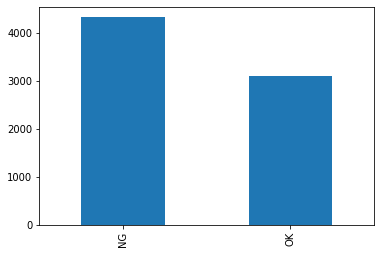

In [6]:

s.image.loadImages(casout={'name':'train','blocksize':64,'replace':True},
                   path=train_data_dir, recurse = 'True', labellevels=1)

s.image.processimages(casout={'name':'train_resized','replace':True},
                      imagefunctions=
                      [
                       {
                        'functionoptions':{'functiontype':'resize','h':size,'w':size}
                       }
                      ],
                     imagetable=dict(name='train'))

trainTbl=s.CASTable('train_resized')
trainTbl["_label_"].value_counts().plot.bar()
plt.show()

In [9]:
random_seed = 9898
# 60% Train, 10% Validation, 30% Testing

if(Split):
    train_img_table,valid_img_table,test_img_table = three_way_split(trainTbl,valid_rate=10, test_rate=30, im_table=True, stratify=True)
else:
    train_img_table,valid_img_table = two_way_split(trainTbl, test_rate=10, im_table=True, stratify=True)
    
print("OK Train Cnt:",(train_img_table['_label_'] == "OK").sum())
print("NG Train Cnt:",(train_img_table['_label_'] == "NG").sum())
print(train_img_table.channel_means)

OK Train Cnt: 1855.0
NG Train Cnt: 2593.0
[0.0, 90.59875576101619, 100.9377673718569]


In [10]:
model = VGG16(s, model_table=modelname, 
              n_classes=2, 
              n_channels=1,             
              width=size, 
              height=size, 
              scale=1, 
              offsets=train_img_table.channel_means,
             )

#### if use pre-trained weight
#last_model_out_dir = '/home/sasdemo01/models/'
#model_weight = modelname+'_weights.sashdat'
#model.load_weights(path=last_model_out_dir + model_weight)

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


In [11]:
solOpt = dict(
    learning_rate=0.01, 
        learning_rate_policy='POLY',
    momentum=0.9,
    gamma=0.1,
    use_locking=True)

solver = MomentumSolver(**solOpt)

nloOpts= dict(
    algorithm=solver,
    dropout_type='standard',
    mini_batch_size=batch_size, 
    max_epochs=epoch,
    reg_l2=0.001,
    log_level=3,
    stagnation=10, threshold=1e-3,)

optimizer = Optimizer(**nloOpts)
optimizer.add_optimizer_mode('Synchronous')


## Training

In [12]:
model.fit(data = train_img_table,
          inputs="_image_",
          target="_label_",
          optimizer=optimizer,
          gpu=dict(useGPU=True,device=gpus),
          valid_table=valid_img_table,
          save_best_weights=dict(name='bestweights', replace=True),
          force_equal_padding=True
          )

NOTE: Training from scratch.
NOTE: Using sas-instance.nchc.org.tw: 4 out of 8 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 65061570.
NOTE:  The approximate memory cost is 2348.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      53.30 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 64.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 2048.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:      2
NOTE:  Levels for the target variable:
NOTE:  Level      0: NG
NOTE:  Level      1: OK
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0  2048     0.01           0.6828     0.4312      12.42    31.78
NOTE:      1  2048     0.01

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0  2048 0.007099           0.5421     0.2695      12.31     0.83
NOTE:      1  2048 0.007099           0.5277     0.2666      12.31     0.82
NOTE:      2   352 0.007099           0.5275     0.2756       12.3     0.18
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   741 0.007099           0.5103     0.2834     0.11
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  11       0.0071          0.5343     0.2687           0.5103           0.2834     1.94
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0  2048 0.006817           0.5184     0.2783       12.3     0.83
NOTE:      1  2048 0.006817           0.5144     0.2832       12.3     0.82
NOTE:      2   352 0.006817           0.5081     0.2557      12.29     0.18
NOTE:  Batch nUsed Learning Rate     

NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0  2048 0.002991            0.385     0.1963       12.2     0.83
NOTE:      1  2048 0.002991           0.3888      0.208      12.19     0.83
NOTE:      2   352 0.002991           0.3321     0.1676      12.19     0.18
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error   Time(s) (Validation)
NOTE:      0   741 0.002991           0.3978     0.2051     0.11
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  24        0.003          0.3825     0.1994           0.3978           0.2051     1.95
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0  2048 0.002608           0.3864     0.1943      12.19     0.83
NOTE:      1  2048 0.002608           0.3926     0.2031      12.19     0.82
NOTE:      2   352 0.002608           0.3236     0.1705      12.19     0.18
NOTE:  Batch nUsed Learning Rate     

,Descr,Value
0,Model Name,s1_5143_t_sr1+dam_osp+sop_01_01_vgg16
1,Model Type,Convolutional Neural Network
2,Number of Layers,22
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,13
6,Number of Pooling Layers,5
7,Number of Fully Connected Layers,2
8,Number of Weight Parameters,65049152
9,Number of Bias Parameters,12418


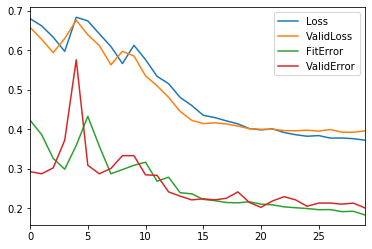

In [14]:
model.training_history[['Loss','ValidLoss','FitError', 'ValidError']].plot()

## Evaluat on Training data and find threshold

In [15]:
pred_table_train = model.predict(data=train_img_table, use_best_weights=True, gpu = dict(useGPU=True,device={4,5,6,7}))["OutputCasTables"]
pred_table_train = s.CASTable(pred_table_train["Name"].item())
pred_out_train = pred_table_train[["_label_", "_path_", "P__label_OK", "I__label_"]]
pred_out_train = pd.DataFrame(pred_out_train.to_frame())
pred_out_train.columns = ["Flag", "Filename", "OK_Prob.", "P_label"]

ori_cm_train=pd.crosstab(pred_out_train.Flag,pred_out_train.P_label,margins=True)
ori_cm_train.index =['True_NG','True_OK','All']
ori_cm_train.columns = ['Predict_NG','Predict_OK','All']

print("On Training")
print("ACC: ", str(round((ori_cm_train.Predict_NG[0]+ori_cm_train.Predict_OK[1])/ori_cm_train.All[2]*100,2)),"%\n")
print("Escape Rate = ",str(round(ori_cm_train.Predict_OK[0]/ori_cm_train.All[2],2)), "%\n")
print("Overkill = ",round(ori_cm_train.Predict_NG[1]/ori_cm_train.All[2]*100,2), "%\n")
print(ori_cm_train)

NOTE: Using the weights providing the smallest loss error.
NOTE: Using sas-instance.nchc.org.tw: 4 out of 8 available GPU devices.
On Training
ACC:  82.19 %

Escape Rate =  0.07 %

Overkill =  11.22 %

         Predict_NG  Predict_OK   All
True_NG        2300         293  2593
True_OK         499        1356  1855
All            2799        1649  4448


/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [16]:
cnt=int(pred_out_train.shape[0]*300/1000000)
threshold=sorted(pred_out_train[(pred_out_train['Flag'] =='NG')&(pred_out_train['P_label'] =='OK')]['OK_Prob.'],reverse=True)[cnt]
pred_out_train['P_label_New_TH'] = pred_out_train['OK_Prob.'].apply(lambda x: 'NG' if x <= threshold else 'OK')

In [17]:
threshold

0.9859468936920166

## Evaluate on Test Data (if Split=True)
Use Training Threshold

In [45]:
pred_table = model.predict(data=test_img_table, use_best_weights=True, gpu = dict(useGPU=True,device={4,5,6,7}))["OutputCasTables"]
pred_table = s.CASTable(pred_table["Name"].item())
pred_out = pred_table[["_label_", "_path_", "P__label_OK", "I__label_"]]
pred_out = pd.DataFrame(pred_out.to_frame())
pred_out.columns = ["Flag", "Filename", "OK_Prob.", "P_label"]
ori_cm=pd.crosstab(pred_out.Flag,pred_out.P_label,margins=True)
ori_cm.index =['True_NG','True_OK','All']
ori_cm.columns = ['Predict_NG','Predict_OK','All']
print("==========Origin==============")
print("ACC: ", str(round((ori_cm.Predict_NG[0]+ori_cm.Predict_OK[1])/ori_cm.All[2]*100,2)),"%\n")
print("Escape Rate = ",str(round(ori_cm.Predict_OK[0]/ori_cm.All[2],2)), "%\n")
print("Overkill = ",round(ori_cm.Predict_NG[1]/ori_cm.All[2]*100,2), "%\n")
print(ori_cm)

print("==========Adjusted==============")
pred_out['P_label_New_TH'] = pred_out['OK_Prob.'].apply(lambda x: 'NG' if x <= threshold else 'OK')
cm=pd.crosstab(pred_out.Flag, pred_out.P_label_New_TH, margins=True)
#print ("For data:",test_data_dir) 
print("when threshold = ", threshold,":\n")
print(cm,"\n")
print("Accuracy = ", round((cm.NG[0]+cm.OK[1])/cm.All[2]*100,2), "%")
print("Escape Rate = ", round(cm.OK[0]/cm.All[2]*1000000,2), "ppm")
print("Overkill = ", round(cm.NG[1]/cm.All[2]*100,2), "%")


NOTE: Using the weights providing the smallest loss error.
NOTE: Using sas-instance.nchc.org.tw: 4 out of 8 available GPU devices.
==========Origin==============
ACC:  78.88 %

Escape Rate =  0.08 %

Overkill =  12.72 %

         Predict_NG  Predict_OK   All
True_NG        1110         187  1297
True_OK         283         645   928
All            1393         832  2225
==========Adjusted==============
when threshold =  0.9859468936920166 :

P_label_New_TH    NG   OK   All
Flag                           
NG              1289    8  1297
OK               762  166   928
All             2051  174  2225 

Accuracy =  65.39 %
Escape Rate =  3595.51 ppm
Overkill =  34.25 %


/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


### Visulization Result

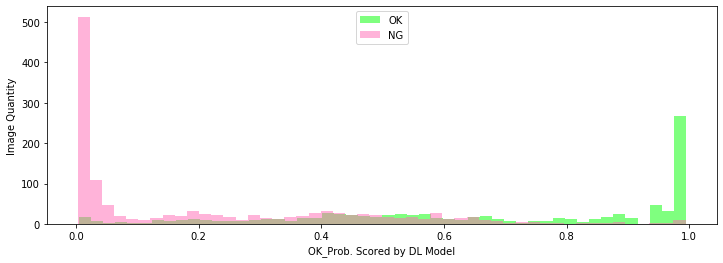

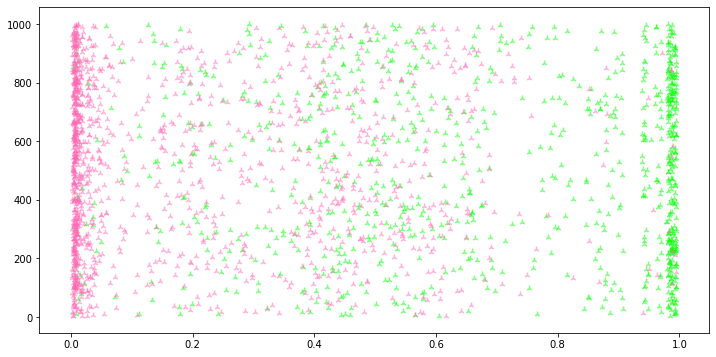

In [46]:
%matplotlib inline
from matplotlib import pyplot

pyplot.figure(figsize=(12,4))
pyplot.xlabel('OK_Prob. Scored by DL Model')
pyplot.ylabel('Image Quantity')
pyplot.hist(pred_out[pred_out['Flag']=='OK']['OK_Prob.'], bins=50, alpha=0.5, label='OK', color='lime')#''lime')
pyplot.hist(pred_out[pred_out['Flag']=='NG']['OK_Prob.'], bins=50, alpha=0.5, label='NG',color='hotpink')#'hotpink')
pyplot.legend(loc='upper center')
pyplot.show()

pred_out['randNumCol'] = np.random.randint(0,1000, size=len(pred_out))
pyplot.figure(figsize=(12,6))
pyplot.scatter(pred_out[pred_out['Flag']=='OK']['OK_Prob.'], pred_out[pred_out['Flag']=='OK']['randNumCol'],marker='2', alpha=0.5, label='OK', color='lime')
pyplot.scatter(pred_out[pred_out['Flag']=='NG']['OK_Prob.'], pred_out[pred_out['Flag']=='NG']['randNumCol'],marker='2', alpha=0.5, label='OK', color='hotpink')
pyplot.show()



/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/swat/cas/table.py:9147: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return self._fetch().ix[:, 0].tolist()


NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sasdemo01).


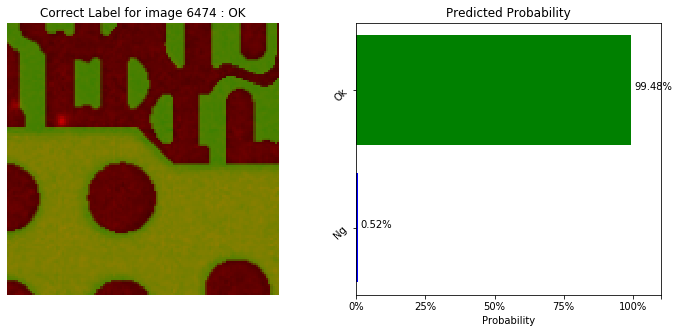

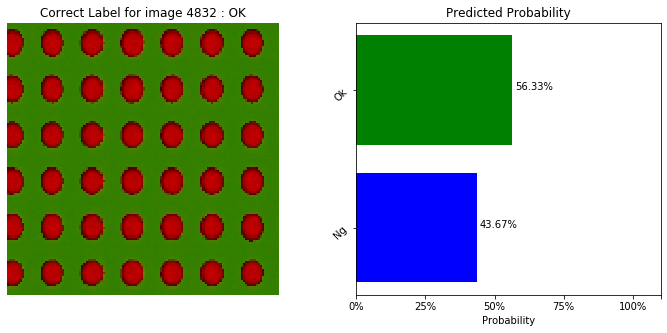

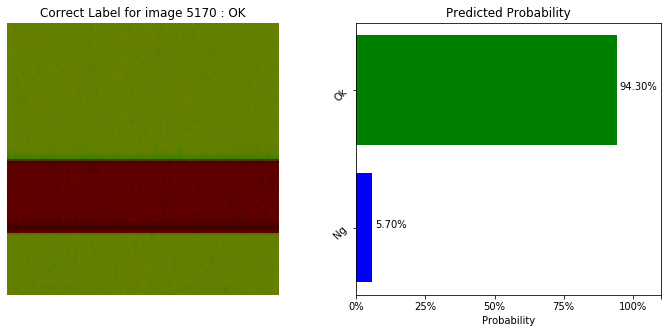

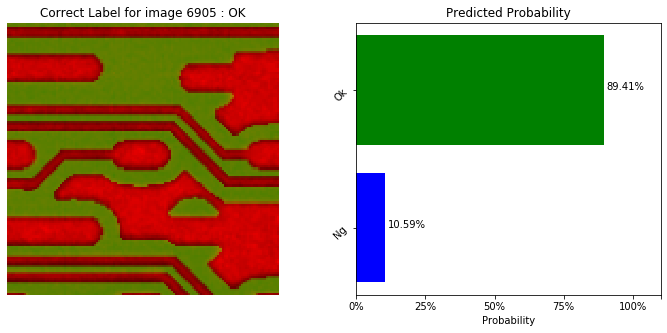

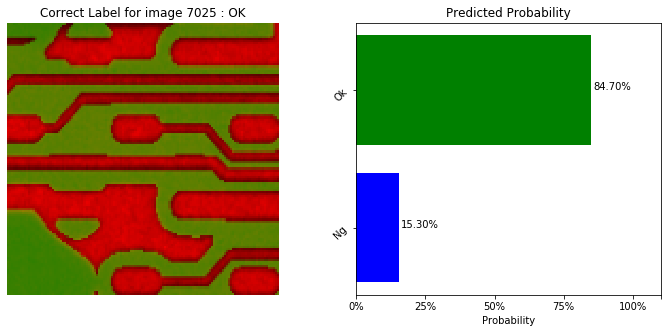

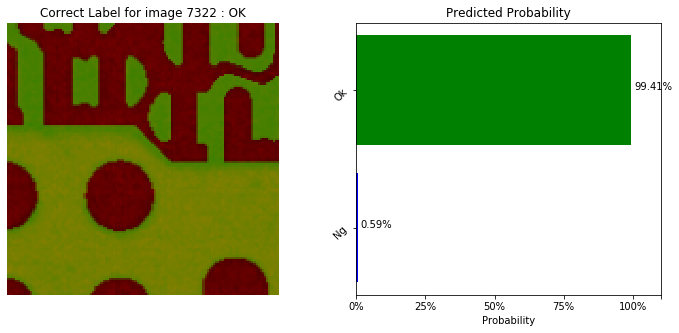

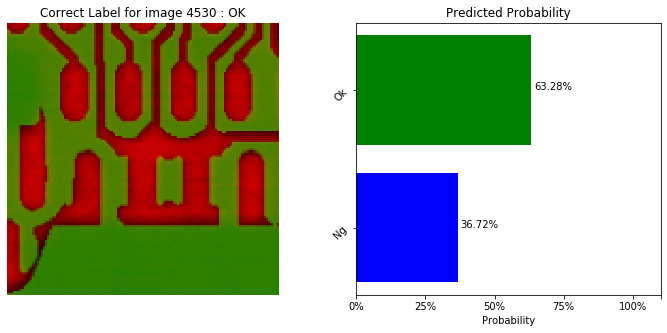

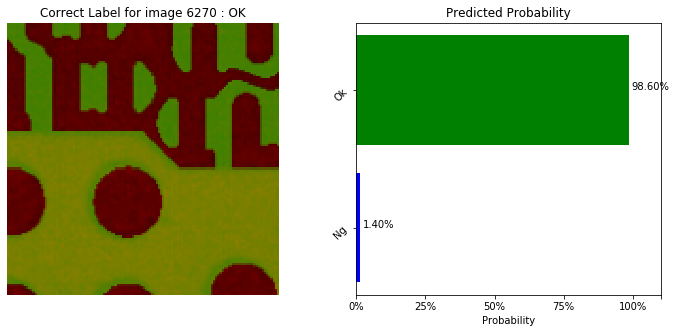

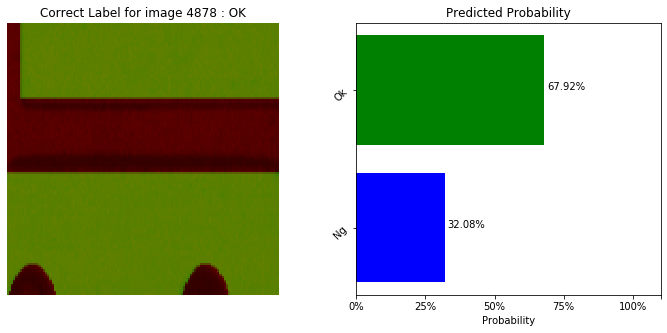

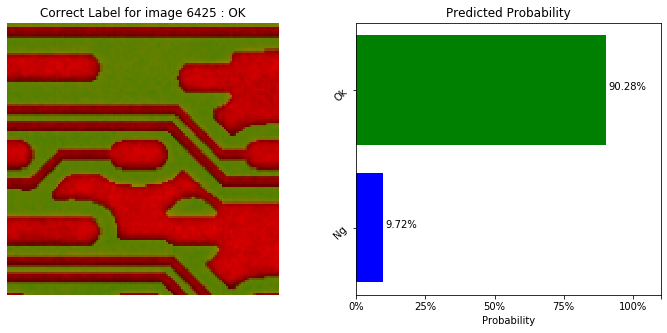

In [47]:
## Label: OK Predict: OK
model.plot_evaluate_res(img_type='C', label_class='OK',randomize=True, n_images=10)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sasdemo01).


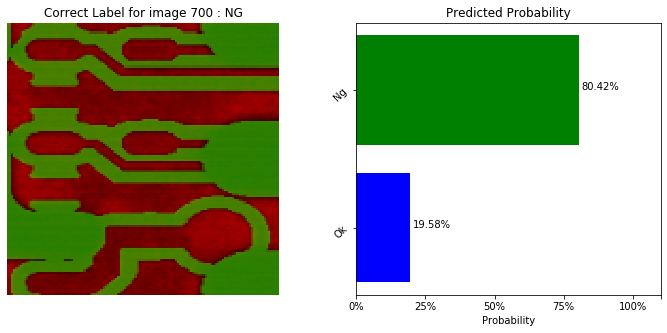

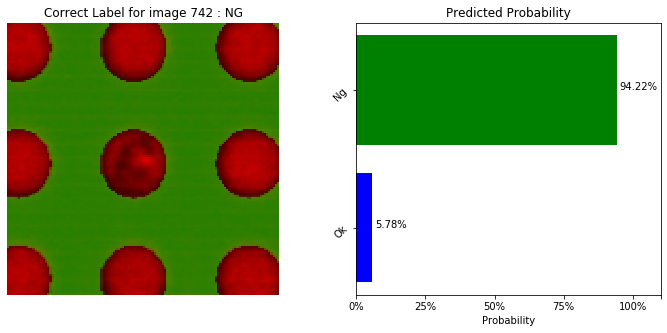

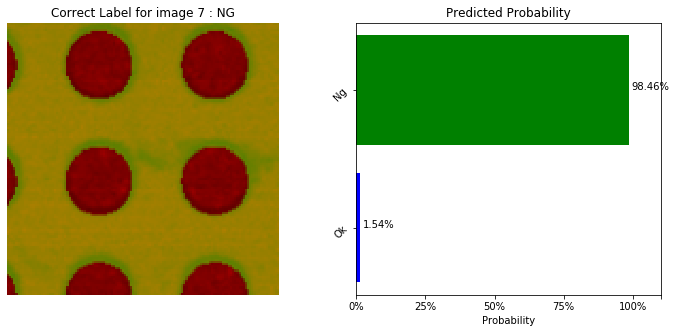

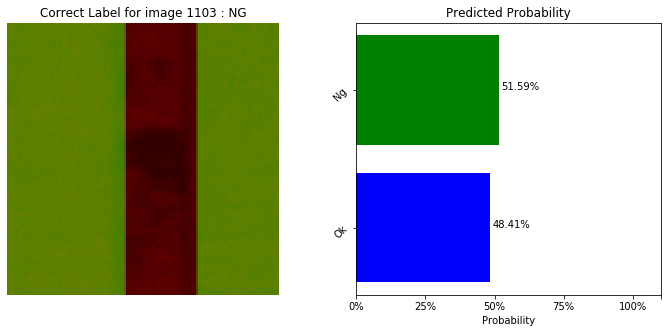

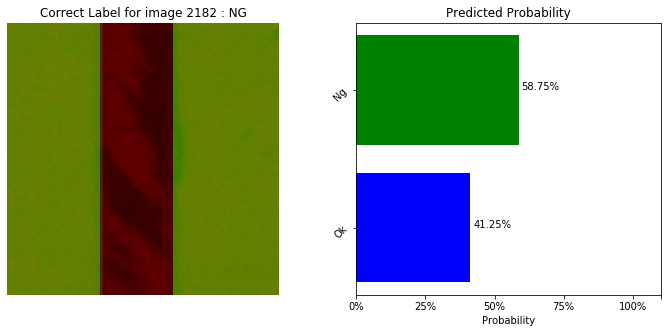

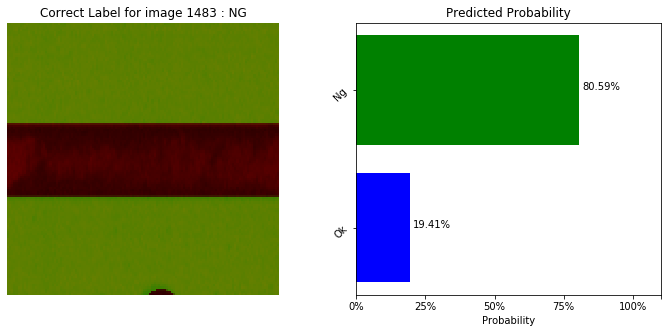

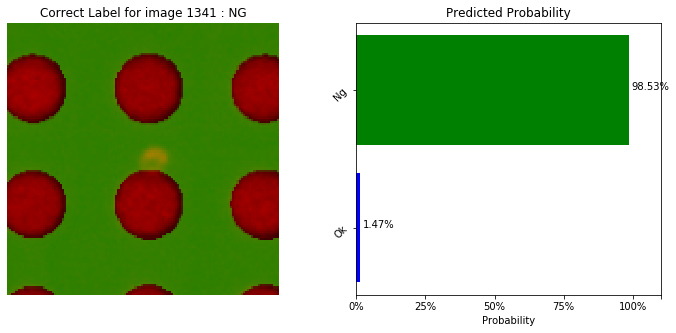

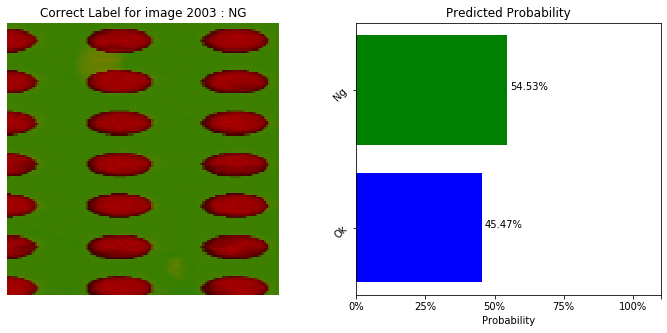

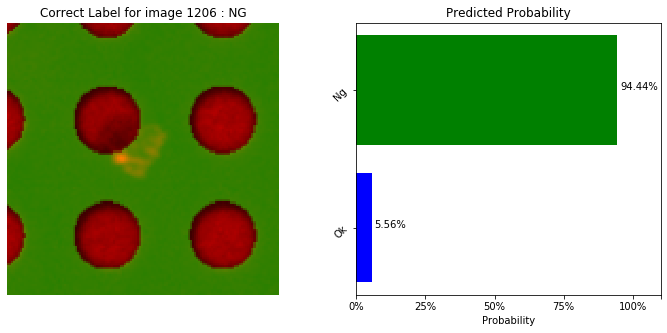

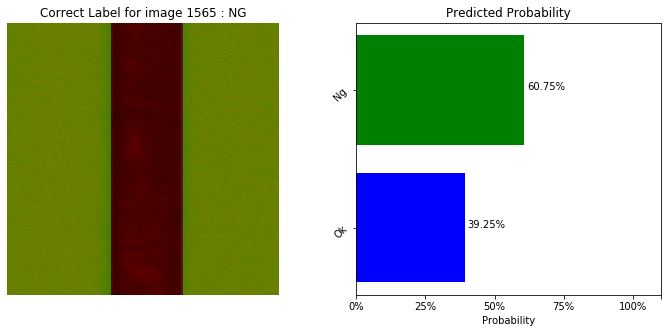

In [48]:
## Label: NG Predict: NG
model.plot_evaluate_res(img_type='C', label_class='NG',randomize=True, n_images=10)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sasdemo01).


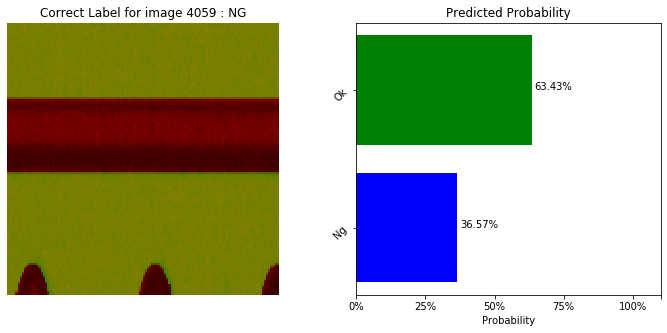

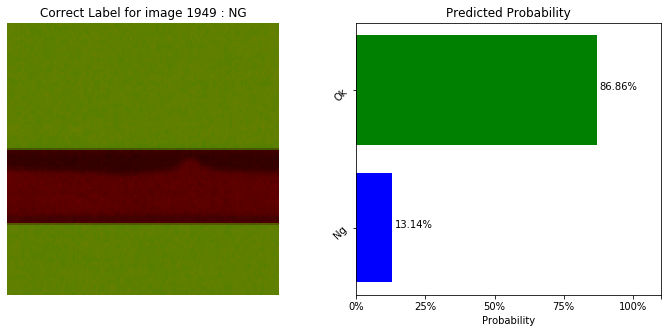

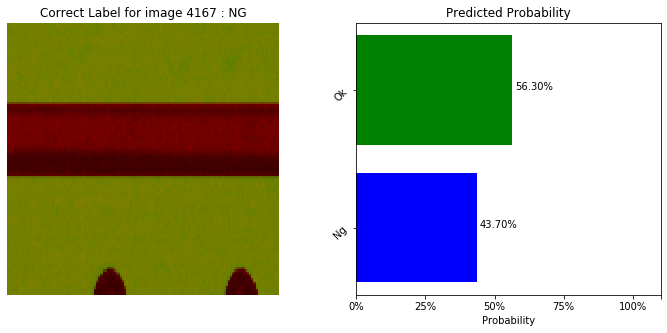

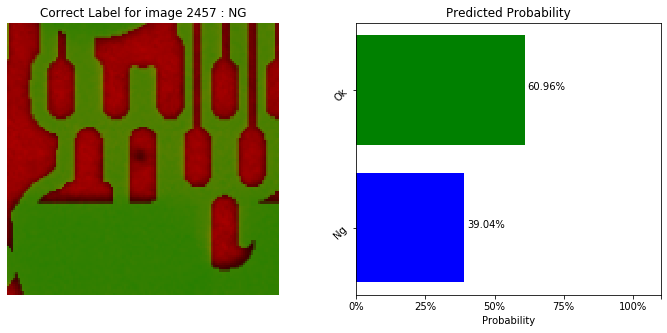

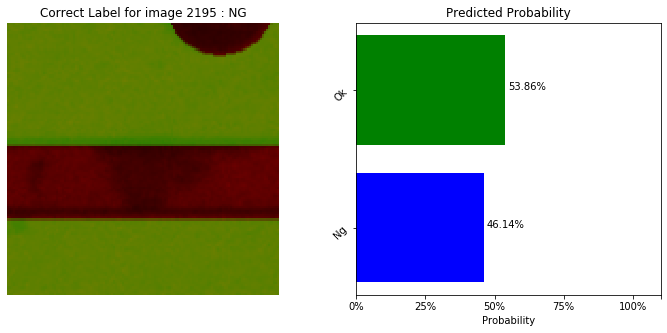

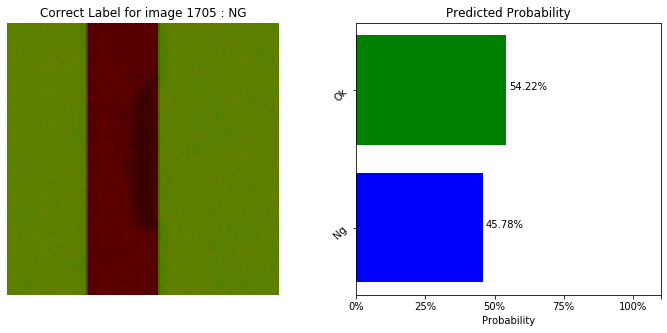

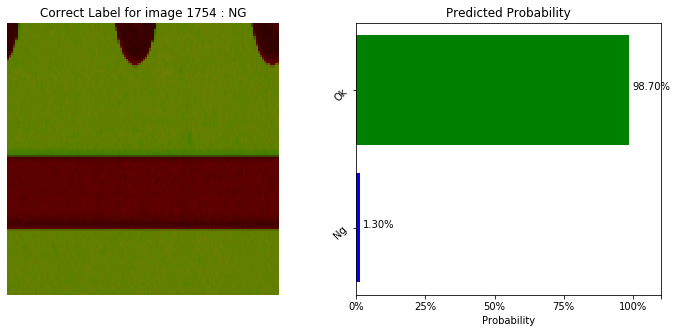

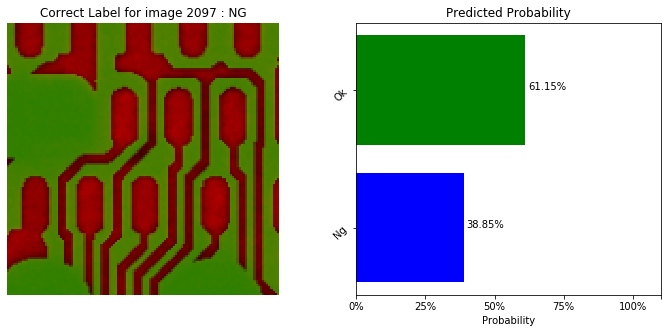

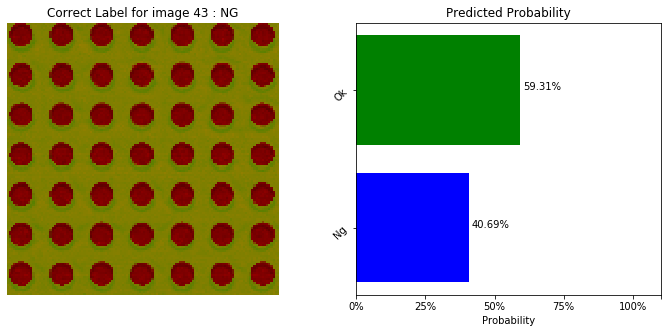

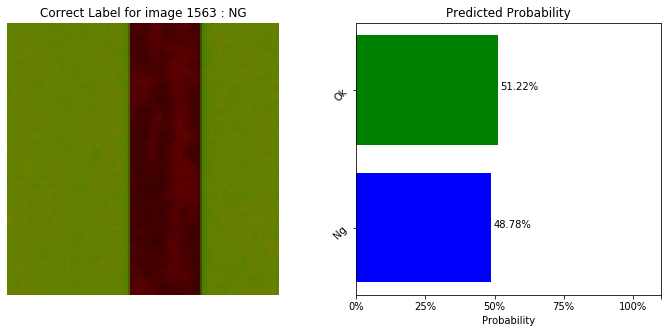

In [49]:
## Label: NG Predict: OK
model.plot_evaluate_res(img_type='M', label_class='NG',randomize=True, n_images=10)

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sasdemo01).


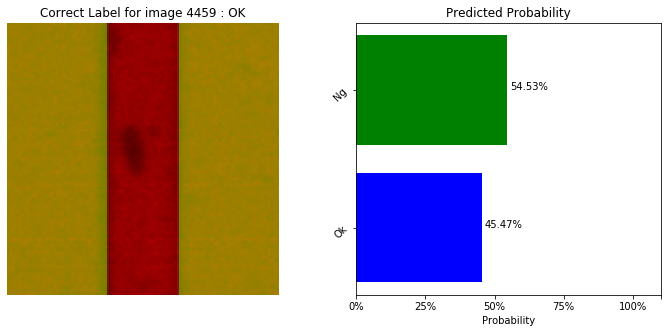

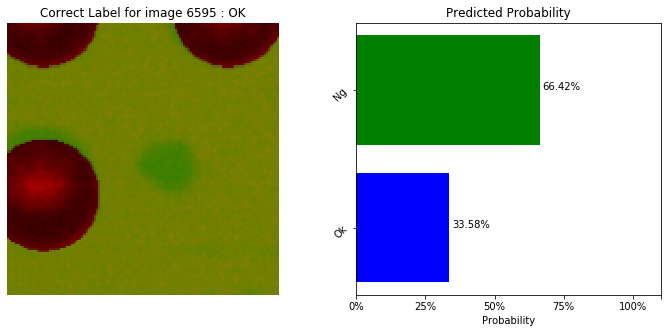

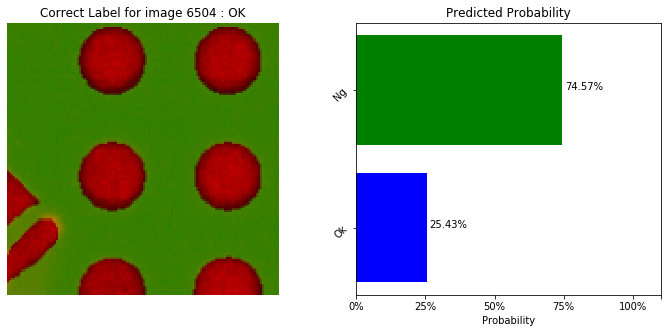

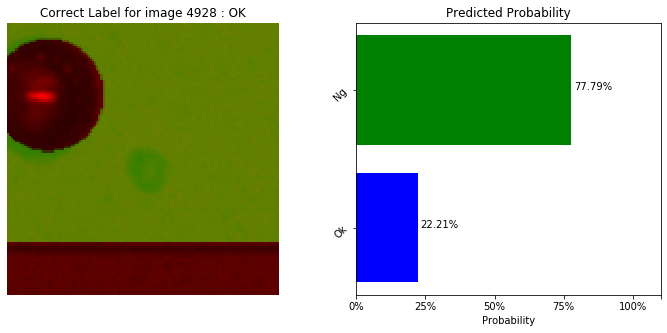

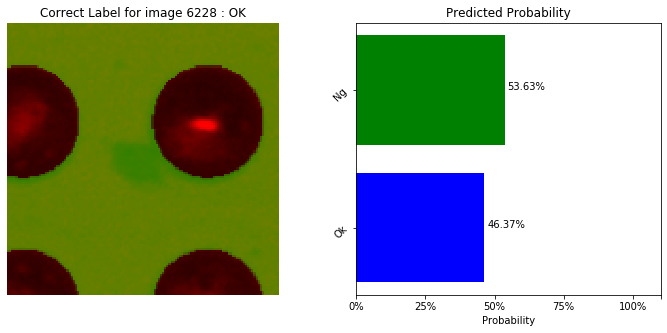

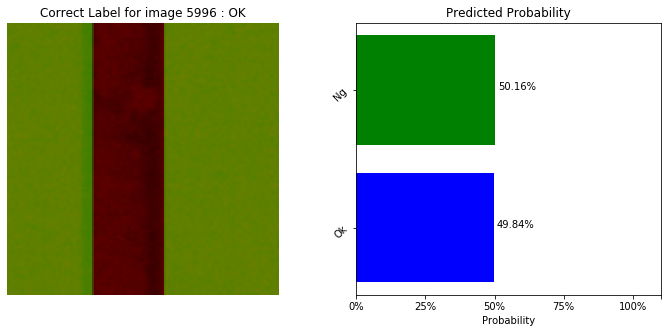

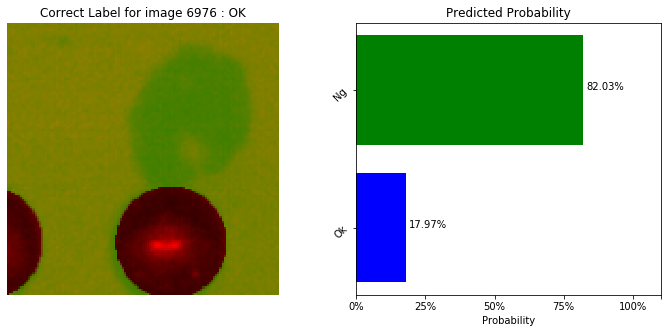

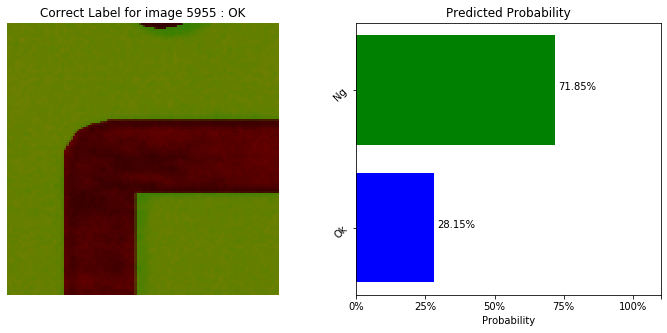

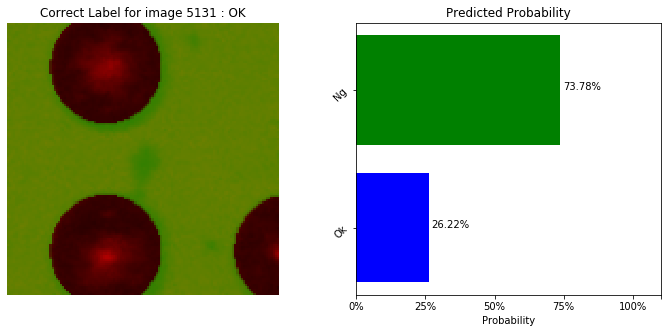

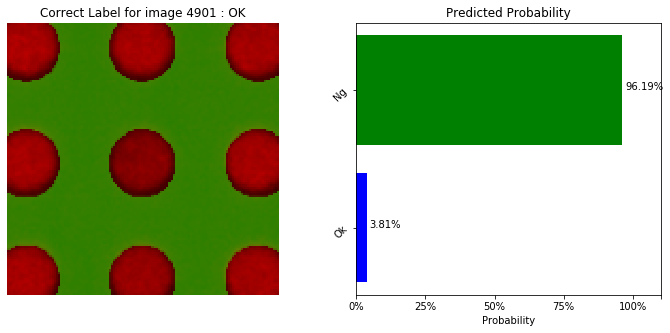

In [50]:
## Label: OK Predict: NG
model.plot_evaluate_res(img_type='M', label_class='OK',randomize=True, n_images=10)

## Save

In [43]:
if(save_check):
    pred_table = model.predict(data=trainTbl, use_best_weights=True, gpu = dict(useGPU=True,device={4,5,6,7}))["OutputCasTables"]
    pred_table = s.CASTable(pred_table["Name"].item())
    pred_out = pred_table[["_label_", "_path_", "P__label_OK", "I__label_"]]
    pred_out = pd.DataFrame(pred_out.to_frame())
    pred_out.columns = ["Flag", "Filename", "OK_Prob.", "P_label"]

NOTE: Using the weights providing the smallest loss error.
NOTE: Using sas-instance.nchc.org.tw: 4 out of 8 available GPU devices.


/home/sasdemo01/anaconda3/envs/py3_6_6/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
## Save model as sasdataset
model.deploy(path=model_out_dir, output_format='table')

## Save threshold and channel mean
fp = open(model_out_dir+"/"+modelname+"_info.txt","w")
fp.write(str(threshold)+'\n')
fp.write(str(train_img_table.channel_means[0])+'\n')
fp.write(str(train_img_table.channel_means[1])+'\n')
fp.write(str(train_img_table.channel_means[2])+'\n')
fp.close()

## Save Result
if not os.path.exists(result_out_dir):
    os.mkdir(result_out_dir)
if(save_check):
    pred_out[pred_out.Flag!=pred_out.P_label].to_csv(result_out_dir+'/checklist.csv')


NOTE: Model table saved successfully.
